In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

# 加载数据（假设 CSV 文件在当前工作目录）
train_df = pd.read_csv(r"C:\Users\86135\Desktop\5703\train_smote.csv")
test_df  = pd.read_csv(r"C:\Users\86135\Desktop\5703\test_smote.csv")
X_train = train_df.drop(columns=['failure mode']).values.astype(np.float32)
y_train = train_df['failure mode'].values
X_test  = test_df.drop(columns=['failure mode']).values.astype(np.float32)
y_test  = test_df['failure mode'].values

# 类别编码（假设标签已为整数，此处将其映射为 0,1,...）
classes = np.unique(y_train)
y_train_enc = np.array([np.where(classes==y)[0][0] for y in y_train])
y_test_enc  = np.array([np.where(classes==y)[0][0] for y in y_test])

# 特征标准化（训练集拟合后同时变换训练集和测试集）
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print(f"训练集样本数: {X_train_scaled.shape[0]}, 测试集样本数: {X_test_scaled.shape[0]}, 特征维度: {X_train_scaled.shape[1]}")


训练集样本数: 600, 测试集样本数: 86, 特征维度: 69


In [3]:
# 定义 MAML 风格的 MLP（仅结构，不做元训练）
class MAMLLearner(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(MAMLLearner, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        # 输出层维度为类别数
        self.fc2 = nn.Linear(hidden_dim, len(classes))
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 初始化模型和优化器
mlp = MAMLLearner(input_dim=X_train_scaled.shape[1], hidden_dim=64)
optimizer1 = torch.optim.Adam(mlp.parameters(), lr=0.01)
criterion1 = nn.CrossEntropyLoss()

# 转换数据为 torch 张量
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc,   dtype=torch.long)
X_test_tensor  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc,    dtype=torch.long)

# 训练 MLP
num_epochs = 200
for epoch in range(num_epochs):
    mlp.train()
    optimizer1.zero_grad()
    outputs = mlp(X_train_tensor)
    loss = criterion1(outputs, y_train_tensor)
    loss.backward()
    optimizer1.step()
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# 获取 MLP 模型对训练集和测试集的预测概率
mlp.eval()
with torch.no_grad():
    logits_train = mlp(X_train_tensor)
    logits_test  = mlp(X_test_tensor)
    prob_maml_train = torch.softmax(logits_train, dim=1).numpy()
    prob_maml_test  = torch.softmax(logits_test,  dim=1).numpy()


Epoch 50/200, Loss: 0.0229
Epoch 100/200, Loss: 0.0054
Epoch 150/200, Loss: 0.0024
Epoch 200/200, Loss: 0.0014


In [5]:
# 定义原型网络的嵌入模型
class EmbeddingNet(nn.Module):
    def __init__(self, input_dim, embedding_dim=16):
        super(EmbeddingNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, embedding_dim)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 初始化嵌入模型和优化器
embed_model = EmbeddingNet(input_dim=X_train_scaled.shape[1], embedding_dim=16)
optimizer2 = torch.optim.Adam(embed_model.parameters(), lr=0.005)

# 将训练集按类别分组，便于采样
train_data_by_class = {
    cls: torch.tensor(X_train_scaled[y_train_enc==cls], dtype=torch.float32)
    for cls in classes
}

# 定义一次 episode 的训练过程（支持集 + 查询集）
def train_episode(embed_model, n_support=5, n_query=5):
    embed_model.train()
    episode_classes = list(classes)
    support_data, query_data = [], []
    support_labels, query_labels = [], []

    for cls in episode_classes:
        data = train_data_by_class[cls]
        if len(data) < n_support + n_query:
            continue  # 样本不足跳过
        idx = np.random.choice(len(data), size=n_support+n_query, replace=False)
        support_data.append(data[idx[:n_support]])
        query_data.append(data[idx[n_support:]])
        support_labels += [cls]*n_support
        query_labels   += [cls]*n_query

    support_data = torch.cat(support_data)
    query_data   = torch.cat(query_data)
    support_labels = torch.tensor(support_labels, dtype=torch.long)
    query_labels   = torch.tensor(query_labels, dtype=torch.long)

    support_embeddings = embed_model(support_data)
    prototypes = []
    for cls in episode_classes:
        cls_support_idx = (support_labels == cls)
        if cls_support_idx.sum() == 0:
            continue  # 如果这个类在本 batch 里没有采样到，跳过
        cls_embed = support_embeddings[cls_support_idx]
        prototypes.append(cls_embed.mean(dim=0))
    prototypes = torch.stack(prototypes)

    query_embeddings = embed_model(query_data)
    dist_matrix = ((query_embeddings.unsqueeze(1) - prototypes.unsqueeze(0))**2).sum(dim=2)
    log_p_y = F.log_softmax(-dist_matrix, dim=1)

    # 注意要重新编号 query labels
    target = torch.arange(len(prototypes)).repeat_interleave(n_query)
    loss = F.nll_loss(log_p_y, target)

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    return loss.item()


# 进行多次 episode 训练
num_episodes = 1000
for episode in range(1, num_episodes+1):
    loss = train_episode(embed_model, n_support=5, n_query=5)
    if episode % 200 == 0:
        print(f"Episode {episode}/{num_episodes}, Loss: {loss:.4f}")

# 训练完成后，计算每个类别的原型向量（在整个训练集上）
embed_model.eval()
with torch.no_grad():
    prototypes = []
    for cls in classes:
        cls_data = train_data_by_class[cls]
        cls_embed = embed_model(cls_data)
        prototypes.append(cls_embed.mean(dim=0))
    prototypes = torch.stack(prototypes)  # 形状 [num_classes, embedding_dim]
    # 计算训练集嵌入
    train_embeddings = embed_model(torch.tensor(X_train_scaled, dtype=torch.float32))
    # 计算训练集中每个样本与各原型的距离，并转为概率
    dist_train = ((train_embeddings.unsqueeze(1) - prototypes.unsqueeze(0))**2).sum(dim=2)
    prob_proto_train = torch.softmax(-dist_train, dim=1).numpy()
    # 对测试集做同样计算
    test_embeddings = embed_model(torch.tensor(X_test_scaled, dtype=torch.float32))
    dist_test = ((test_embeddings.unsqueeze(1) - prototypes.unsqueeze(0))**2).sum(dim=2)
    prob_proto_test = torch.softmax(-dist_test, dim=1).numpy()


Episode 200/1000, Loss: 0.0005
Episode 400/1000, Loss: 0.0021
Episode 600/1000, Loss: 0.1834
Episode 800/1000, Loss: 0.0001
Episode 1000/1000, Loss: 0.0000


✅ Final ISE System Performance:
Accuracy: 0.8488
Macro Precision: 0.6961
Macro Recall: 0.7300
Macro F1: 0.7073

Classification Report:
              precision    recall  f1-score   support

           0     0.8684    0.8919    0.8800        37
           1     0.4000    0.3333    0.3636         6
           2     0.9444    0.8947    0.9189        38
           3     0.5714    0.8000    0.6667         5

    accuracy                         0.8488        86
   macro avg     0.6961    0.7300    0.7073        86
weighted avg     0.8521    0.8488    0.8488        86



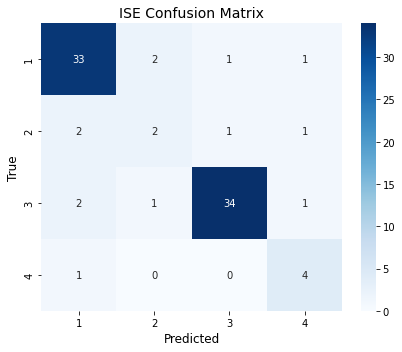

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# 计算各项指标
accuracy = accuracy_score(y_test_enc, y_pred)
precision = precision_score(y_test_enc, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test_enc, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test_enc, y_pred, average='macro', zero_division=0)

# 打印总体性能
print("✅ Final ISE System Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1: {f1:.4f}")

# 打印详细分类报告
print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, digits=4))

# 绘制混淆矩阵
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.title("ISE Confusion Matrix", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.tight_layout()
plt.show()
